# random change in erodibility by fire

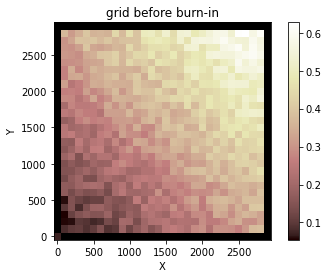

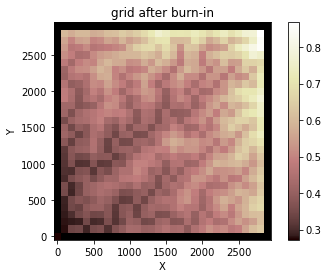

-- 0 years -- 0.1 seconds --
fire at (2000.0,2400.0) with 21 nodes inflamed
fire at (1000.0,1000.0) with 5 nodes inflamed
fire at (500.0,200.0) with 5 nodes inflamed
fire at (900.0,400.0) with 5 nodes inflamed
-- 1000 years -- 2.5 seconds --
fire at (700.0,100.0) with 61 nodes inflamed
fire at (1300.0,400.0) with 129 nodes inflamed
fire at (200.0,2700.0) with 1 nodes inflamed
fire at (1500.0,700.0) with 1 nodes inflamed
fire at (400.0,0.0) with 67 nodes inflamed
fire at (500.0,1800.0) with 1 nodes inflamed
fire at (800.0,2600.0) with 1 nodes inflamed
-- 2000 years -- 4.7 seconds --
fire at (1800.0,1800.0) with 1 nodes inflamed
fire at (700.0,1100.0) with 285 nodes inflamed


KeyboardInterrupt: 

In [18]:
import numpy as np
from firemodel import *
import matplotlib.pyplot as plt 
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler # this makes plots
                               )
from landlab.io.netcdf import (write_netcdf, load_netcdf)
from landlab import (RasterModelGrid,
                     imshow_grid)
%matplotlib inline
import time

save=True # save or not? 
save_dir = './simul/' # the place to save the output
dt = 50 # timestep in years
runtime = 10000 # length of the simulation in years
dx = 100 # size of a cell in ...m ? 
#np.random.seed(5000) # reproducible yet random

# 5x5 grid with baselevel in lower left corner
# all other boundary nodes closed
# init topography is plane tilted up to the upper right with noise

grid_dim = (30,30)
#grid_dim = (10,10)
mg = RasterModelGrid(grid_dim, xy_spacing=dx) # 3km x 3km 
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] += (mg.node_y / 10000. + 
                                         mg.node_x / 10000. + np.random.rand(len(mg.node_y)) / 10.) # sloped up
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
     0, mg.at_node['topographic__elevation'], -9999.)

# show the pre-burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()

#Instantiate Fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=.001,
    m_sp=.5,
    n_sp=1)

# burn in an initial drainage ntework using the fastscape eroder
for it in range(100):
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=dt)
    mg.at_node['topographic__elevation'][0] -= 0.003 # Uplift
    
    
# add soil to the drainage network
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']


# plot after burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()


# init the space component
K_sed0 = 0.00001 # the baseline soil erodiblity
K_sed = np.ones(mg.shape)*K_sed0 # the initial soil erodibility per node
ha = Space(
    mg,
    K_sed=K_sed,
    K_br=1e-10,
    F_f=0.5,
    phi=0.1,
    H_star=1.,
    v_s=0.001,
    m_sp=0.5,
    n_sp = 1.0,
    sp_crit_sed=0,
    sp_crit_br=0)


# init the erodibility stepper
decay_time = 15*dt # time it takes the erodibility perturbution to decay
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
# this leads to decay in the erodibility from whatever value it's at.

# init the burner
R_fire_mean = grid_dim[0]/10*dx
fire_freq = 1/(runtime/50)
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=5*K_sed0,
                dt=dt)
# this produces fires whick kick up the erodibility...


start_time = time.time()
for it in range(runtime//dt):
    fr.run_one_step() # accumulate the flow
    df.map_depressions() # find landscape depressions (which do not erode)
    ha.run_one_step(dt=dt) # step the transport model
    es.stepper(ha,dt=dt) # decay the erodibility back to baseline from the former timestep
    burner.fire(ha,mg) # light any fires (increase erodibility)
    mg.at_node['bedrock__elevation'][0] -= 2e-6*dt # add in the uplift
    if it*dt % 1000 == 0:
        print("--", it*dt, "years -- %s seconds --" % round((time.time() - start_time), 1))
    
    if (it*dt % 100 == 0) & save: # save every 100 years
        filename = save_dir + 'simul_%05d.nc'%it
        #mg.(filename, names='topographic__elevation')
        write_netcdf(filename, mg, format="NETCDF3_64BIT", names="topographic__elevation")
        

        
# plot after iteration grid
mg.imshow('node','topographic__elevation')
plt.title('grid after timesteppin')
plt.show()

#Show sediment flux map
fig = plt.figure()
plot = plt.subplot()
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='Blues')
plt.show()



# slope-area plot
area = mg.at_node['drainage_area'][mg.core_nodes]
slope = mg.at_node['topographic__steepest_slope'][mg.core_nodes]

fig = plt.figure()
slope_area_plot = plt.subplot()
slope_area_plot.set_xscale('log')
slope_area_plot.set_yscale('log')
plt.scatter(area, slope)
plt.show()


In [ ]:
np.save('network',nmg,allow_pickle=True)

In [ ]:
mg.save('exampleNetwork.asc', names=['topographic__elevation'])

In [ ]:
np.load('network.npy',allow_pickle=True)

In [ ]:
from create_network import create_network_from_raster
nmg = create_network_from_raster(
    mg,
    method='variable', # method
    n_widths=dx,
    #node_spacing=30,
    #d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

# visualization learning . 

In [ ]:
mg.imshow('node','topographic__elevation')
#graph.plot_nodes(nmg,,markersize=4)
graph.plot_links(nmg,with_id=False)
fig = plt.gcf()
fig.set_size_inches(14, 10)

In [ ]:
np.save('test_grid_forVis',(K_sed,K_sed0))

In [ ]:
zb

In [ ]:
z.shape

In [ ]:
zb.shape

In [ ]:
mask.shape

In [ ]:


# plot the links
graph.plot_links(nmg, with_id=False)


## plot the un-burned areas
z = mg.at_node['topographic__elevation']
zb = (K_sed - K_sed0).flatten() # burned.. 
#nb = np.zeros_like(z) # not burned
tol = K_sed0/2
mask = (K_sed > tol).flatten()

zb[~mask]=np.nan
#zb[mask]=z[mask]

#zb[mask]=np.nan
#znb[~mask]=z[~mask]

zb = zb.reshape(grid_dim)
#znb = znb.reshape(grid_dim)


#def edge_mask(x):
#    mask = np.ones(x.shape, dtype=bool)
#    mask[x.ndim * (slice(1, -1),)] = False
#    return mask
#
#emask = edge_mask(mask.reshape(grid_dim))
#zb[emask] = np.nan
#znb[emask] = np.nan

x = np.arange(0,grid_dim[0]*dx,dx)
y = np.arange(0,grid_dim[0]*dx,dx)
xm,ym = np.meshgrid(x,y) 

z = z.reshape(grid_dim)

plt.pcolormesh(xm,ym,z,alpha=1,cmap='pink')
plt.pcolormesh(xm,ym,zb,alpha=0.3,cmap='Greys',zorder=1,)


In [ ]:
z.flatten()

In [ ]:
plt.pcolormesh(x,y,z)

In [ ]:
graph.plot_links(nmg,with_id=False)
#mg.imshow('node','topographic__elevation')
#plt.imshow(mask*100,cmap='Greys',alpha=0.9)


## plot the un-burned areas
xnode = mg.x_of_node
ynode = mg.y_of_node
z = mg.at_node['topographic__elevation']
xnodem,ynodem = np.meshgrid(xnode,y) 



# this plots the burned areas with a grey colormap
x = np.arange(0,grid_dim[0]*dx,dx)
y = np.arange(0,grid_dim[0]*dx,dx)
xm,ym = np.meshgrid(x,y) 
plt.pcolormesh(xm,ym,mask,alpha=0.2,cmap='Greys')

fig = plt.gcf()
fig.set_size_inches(14, 10)